# Document Q&A With Retrieval Augmented Generation


---

* Author: Gabe Rives-Corbett

---

This notebook demonstrates how to implement Retrieval Augmented Generation with basic automated evaluation. It demonstrates the impact that chunk size, overlap and context length have on model outputs. The notebook will create a Q&A system that allows you to find information based on the Google Cloud Generative AI documentation.

## Getting started

#### Install libraries

In [ ]:
%pip install -q --upgrade --user google-cloud-aiplatform==1.36.1

#### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [2]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>



#### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, you will need to authenticate your environment. To do this, run the new cell below. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [ ]:
import sys

if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Import libraries

In [1]:
import requests
import itertools
import numpy as np
import pandas as pd
import numpy.linalg
import vertexai

from google.api_core import retry
from vertexai.language_models import TextEmbeddingModel, TextGenerationModel
from vertexai.generative_models import GenerativeModel
from tqdm.auto import tqdm
from bs4 import BeautifulSoup, Tag

from IPython.display import display, Markdown

tqdm.pandas()

## Configure notebook environment

### Set the following constants to reflect your environment

In [2]:
# Define project information
PROJECT_ID = "gcp-generative-ai"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI SDK
vertexai.init(project=PROJECT_ID, location=LOCATION)

## Scrape text from GCP GenAI VertexAI documentation via List

Retrieve list of Google documentation URLs from a text file

In [3]:
url = "https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/search/retrieval-augmented-generation/examples/URLs.txt"
response = requests.get(url)

if response.status_code == 200:
    # The request was successful, and the content is in response.text
    content = response.text

URLS = [line.strip() for line in content.splitlines()]

Parse the HTML and extract relevant plain text sections

In [4]:
# Given a Google documentation URL, retrieve a list of all text chunks within h2 sections
def get_sections(url: str) -> list[str]:
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")

    sections = []
    paragraphs = []

    body_div = soup.find("div", class_="devsite-article-body")
    if body_div:  # Check if body_div is not None
        for child in body_div.findChildren():
            if child.name == "p":
                paragraphs.append(child.get_text().strip())
            if child.name == "h2":
                sections.append(" ".join(paragraphs))
                break

    for header in soup.find_all("h2"):
        paragraphs = []
        nextNode = header.nextSibling
        while nextNode:
            if isinstance(nextNode, Tag):
                if nextNode.name in {"p", "ul"}:
                    paragraphs.append(nextNode.get_text().strip())
                elif nextNode.name == "h2":
                    sections.append(" ".join(paragraphs))
                    break
            nextNode = nextNode.nextSibling
    return sections

In [5]:
all_text = [t for url in URLS for t in get_sections(url) if t]

Note that most documents are relatively short, but some are thousands of characters long

Matplotlib is building the font cache; this may take a moment.


array([[<Axes: title={'center': '0'}>]], dtype=object)

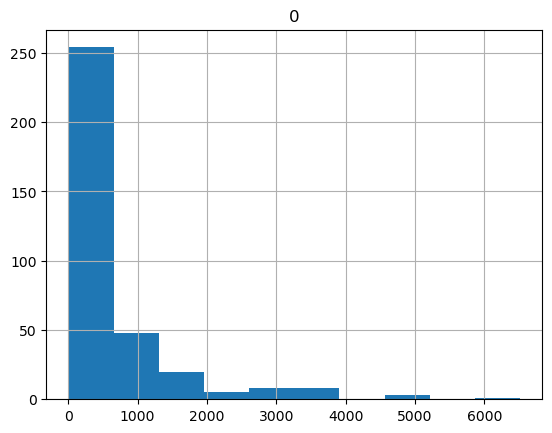

In [6]:
text_lengths = [len(t) for t in all_text]
pd.DataFrame(text_lengths).hist()

## Create vector store

Start by initializing the models

In [27]:
from vertexai.language_models import TextEmbeddingModel
from vertexai.generative_models import GenerativeModel

embeddings_model = TextEmbeddingModel.from_pretrained("text-embedding-004")
text_model = GenerativeModel("gemini-1.5-flash-001")

Create some helper functions for vector similarity and chunking

In [20]:
# Separates seq into multiple chunks in the specified size with the specified overlap
def split_overlap(seq, size, overlap):
    if len(seq) <= size:
        return [seq]
    return ["".join(x) for x in zip(*[seq[i :: size - overlap] for i in range(size)])]


# Compute the cosine similarity of two vectors, wrap as returned function to make easier to use with Pandas
def get_similarity_fn(query_vector):
    def fn(row):
        return np.dot(row, query_vector) / (
            numpy.linalg.norm(row) * numpy.linalg.norm(query_vector)
        )

    return fn


# Retrieve embeddings from the specified model with retry logic
@retry.Retry(timeout=300.0)
def get_embeddings(text):
    return embeddings_model.get_embeddings([text])[0].values

Create the vector store, we are using a Pandas DataFrame

In [21]:
def create_vector_store(texts, chunk_size, overlap):
    vector_store = pd.DataFrame()
    # Insert the individual texts into the vector store
    vector_store["texts"] = list(
        itertools.chain(*[split_overlap(t, chunk_size, overlap) for t in texts])
    )

    # Create embeddings from those texts
    vector_store["embeddings"] = (
        vector_store["texts"].progress_apply(get_embeddings).apply(np.array)
    )

    return vector_store

In [22]:
CHUNK_SIZE = 400
OVERLAP = 50

vector_store = create_vector_store(all_text, CHUNK_SIZE, OVERLAP)

  0%|          | 0/645 [00:00<?, ?it/s]

In [23]:
vector_store.head()

,texts,embeddings
0,This beginner's guide introduces you to the co...,"[-0.01910548098385334, 0.04027912765741348, -0..."
1,In order for generative AI models to generate ...,"[-0.06555181741714478, 0.03770160302519798, -0..."
2,"el. On\nVertex AI, you can customize your mode...","[-0.04964718222618103, 0.016928546130657196, -..."
3,"owered by a generative AI model, the model\nne...","[-0.04946590214967728, 0.05451052635908127, -0..."
4,offensive or insensitive. To maintain safety ...,"[-0.015146843157708645, 0.07577483355998993, -..."


#### push vector store to GCS bucket 

In [24]:
# gs://dev_vector_store
# embed_GCP_documentation_jc.parquet

from google.cloud import storage

# ... (Load your DataFrame and potentially convert to vectors)

vector_store.to_parquet('embed_GCP_documentation_jc.parquet') 

client = storage.Client()
bucket = client.bucket('dev_vector_store')
blob = bucket.blob('embed_GCP_documentation_jc.parquet')
blob.upload_from_filename('embed_GCP_documentation_jc.parquet') 

#### load previous vector store from GCS bucket

In [ ]:
# 1. Connect to GCS and access the file
client = storage.Client()
bucket = client.bucket('dev_vector_store') 
blob = bucket.blob('embed_GCP_documentation_jc.parquet')

# 2. Download to a local file (optional but recommended for larger files)
blob.download_to_filename('local_vector_store.parquet')

# 3. Load into a Pandas DataFrame
vector_store = pd.read_parquet('local_vector_store.parquet')

# Now you have your vector store loaded into the 'df_vectors' DataFrame
print(vector_store.head()) 

## Search the vector store and use for generation

If we send the question to the **foundation model alone, it will hallucinate.**

In [ ]:
response = text_model.generate_content(
    "Can you please provide an breakdown of best practices to embed a entire github repo codebase consisting of python files and notebooks?"
    ).text

display(Markdown(response))

Let's solve this problem by retrieving texts from our vector store and telling the model to use them.

Search the vector store for relevant texts to insert into the prompt by embedding the query and searching for similar vectors.

In [36]:
def get_context(question, vector_store, num_docs):
    # Embed the search query
    query_vector = np.array(get_embeddings(question))

    # Get similarity to all other vectors and sort, cut off at num_docs
    top_matched = (
        vector_store["embeddings"]
        .apply(get_similarity_fn(query_vector))
        .sort_values(ascending=False)[:num_docs]
        .index
    )
    top_matched_df = vector_store[vector_store.index.isin(top_matched)][["texts"]]

    # Return a string with the top matches
    context = " ".join(top_matched_df.texts.values)
    return context

Create a prompt that includes the context and question. Instruct the LLM to only use the context provided to answer the question

In [47]:
def answer_question(question, vector_store, num_docs=10, print_prompt=False):
    context = get_context(question, vector_store, num_docs)
    qa_prompt = f"""Your mission is to answer questions based on a given context.
Context: ```{context}```
Question: ***{question}***
Before you give an answer, make sure it is only from information in the context. If the information is not in the context, just reply "I don't know the answer to that". Think step by step.
Answer: """
    if print_prompt:
        print(qa_prompt)
    result = text_model.generate_content(qa_prompt)
    return result.text

Looking at the fully generated prompt, the context is embedded. Even though the input context is quite messy, the model can now answer factually.

In [ ]:
answer_question(
    "What are the best practices to for generative ai in GCP?",
    vector_store,
    print_prompt=True,
)

In [52]:
response = answer_question(
    "Please give me a breakdown of the current gemini genai models available via python SDK", vector_store
)

display(Markdown(response))

Here's a breakdown of the Gemini models available in the Vertex AI context:

* **Gemini 1.5 Pro:**  This model is capable of code generation, multi-turn chat, advanced reasoning, and multimodal prompts. 
* **Gemini 1.5 Flash:** This model is also capable of code generation. 
* **Gemini 1.0 Pro:** This model can perform code generation tasks.
* **Gemini 1.0 Pro Vision:** This is a multimodal model.

While the context mentions Gemini models, it doesn't specifically mention which ones are available through the Python SDK. It focuses on the Gemini API and doesn't explicitly state the SDK's model availability. 

**Therefore, I don't know the answer to that.** 


## Automated evaluation

This implementation of RAG is dependent on the chunk size, the overlap between the chunks, the number of texts passed into the context and the prompt. Let's create a simple prompt to evaluate answers to the questions, this will allow us to tweak the parameters and see how those tweaks compare.

In [ ]:
def eval_answer(question, answer, context):
    eval_prompt = f"""Your mission is to evaluate answers to questions based on a given context. Remember that before you give an answer, you must check to see if it complies with your mission.

Context: ```{context}```
Question: ***{question}***
Answer: "{answer}"

Respond only with a number from 0 to 5. Think step by step. If the provided answer is not in the context, reply 5 if it is "I don't know the answer to that" otherwise reply 0.
Relevance: """
    # Stop sequence to cut the model off after outputting an integer
    result = text_model.predict(
        eval_prompt, temperature=0, max_output_tokens=1, stop_sequences=[".", " "]
    )
    return int(result.text)

Pass several questions in and retrieve the evaluations

In [ ]:
questions = [
    "What release stage is the RLHF tuning feature?",
    "Can I generate hate speech with text bison?",
    "What format should my batch prediction in put be in?",
    "How can I get the number of tokens?",
    "How do I create a custom style model?",
    "What is the dimensionality of the vector created by the multimodal model?",
    "How long will a stable model version be available?",
]

In [ ]:
answers = [answer_question(q, vector_store) for q in questions]
contexts = [get_context(q, vector_store, 10) for q in questions]
idks = ["I don't know" in a for a in answers]
evals = [
    (question, answer, context, eval_answer(question, answer, context), idk)
    for question, answer, context, idk in zip(questions, answers, contexts, idks)
]

In [ ]:
pd.DataFrame(evals, columns=["question", "answer", "context", "score", "idk"])

Now adjust the parameters and see the difference in performance

In [ ]:
def eval_on_params(chunk_size, overlap, num_docs):
    vector_store = create_vector_store(all_text, chunk_size, overlap)
    answers = [answer_question(q, vector_store) for q in questions]
    contexts = [get_context(q, vector_store, num_docs) for q in questions]
    idks = ["I don't know" in a for a in answers]
    evals = [
        (question, answer, context, eval_answer(question, answer, context), idk)
        for question, answer, context, idk in zip(questions, answers, contexts, idks)
    ]
    return pd.DataFrame(
        evals, columns=["question", "answer", "context", "score", "idk"]
    )

Smaller chunk sizes takes longer to generate the embeddings

In [ ]:
smaller_context_df = eval_on_params(100, 0, 5)

In [ ]:
smaller_context_df

A larger context size has created more unknowns. When composing LLMs into systems, carefully consider how to measure the performance of each component in the system.

In [ ]:
larger_context_df = eval_on_params(1000, 200, 15)

In [ ]:
larger_context_df